## Imports

In [1]:
from fastai2.vision.all import *
from torchvision.utils import save_image,make_grid

## Datablocks

We will be using mnist datablock for our autoencoders and variational autoencoders

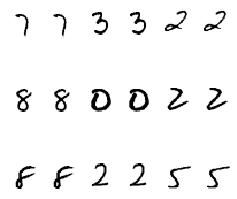

In [2]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training',valid_name='testing')
                  )
dls = mnist.dataloaders(untar_data(URLs.MNIST))
dls.show_batch(max_n=9, figsize=(4,4))

mnist_classifier datablock is just used for extracting labels, that we would use for visualizing the plots.

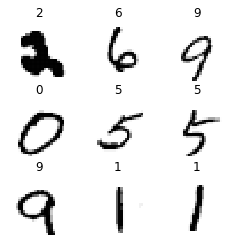

In [3]:
mnist_classifier = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock()), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(train_name='training',valid_name='testing'),
                  get_y=parent_label
                  )
dls_c = mnist_classifier.dataloaders(untar_data(URLs.MNIST))
#Extracting labels for our test data.
z_labels = array([int(dls_c.valid_ds[i][1]) for i in range(dls_c.valid.n)])
dls_c.show_batch(max_n=9, figsize=(4,4))

Download data from [Link](https://www.kaggle.com/jessicali9530/celeba-dataset) for celeb dataset

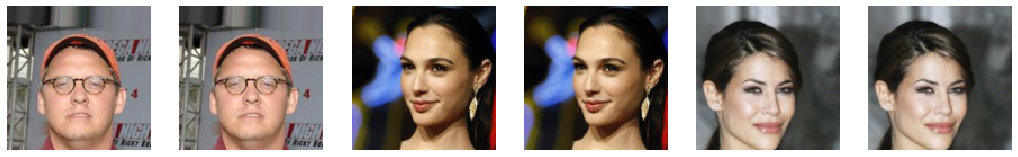

In [40]:
celeb_path = Path('../data/celeb/')
celeb_db = DataBlock(blocks=(ImageBlock(),ImageBlock()),
               get_items=get_image_files,
               item_tfms=[Resize(128)],
               splitter=RandomSplitter(0.05))
dls_celeb = celeb_db.dataloaders(source=celeb_path/'img_align_celeba',bs=64)
dls_celeb.show_batch(max_n=3)

## Utility functions

- show_grid_image used to show a tensor containing images.
- plot_z used to plot 2d points from latent space.

In [11]:
def show_grid_image(tensor, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0, format=None):
    # Slightly modified version of torchvision.utils save_image
    grid = make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    return im

def plot_z(z,labels,sample=None,shuff=True,figsize=(12,12)):
    n = z.shape[0]
    if sample:
        shuff_idxs = np.random.choice(range(n),sample) if shuff else array(range(sample))
        z = z[shuff_idxs]
        labels = labels[shuff_idxs]
    plt.figure(figsize=figsize)
    plt.scatter(z[:,0], z[:,1], alpha=0.5, s=2, cmap='rainbow', c=labels)
    plt.colorbar()

## Training an AutoEncoder

In [29]:
class Encode(Module):
    def __init__(self):
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        
    def forward(self,x):
        x = x.view(-1,784)
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1)
    
class Decode(Module):
    def __init__(self):
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def forward(self,x):
        h3 = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(h3).view(-1,1,28,28))
    
class AE(Module):
    def __init__(self):
        self.encode = Encode()
        self.decode = Decode()
        
    def forward(self,x):
        z = self.encode(x)
        return self.decode(z),z
    

In [13]:
learn_ae = Learner(dls,AE(),loss_func=lambda x,y: F.mse_loss(x[0],y),opt_func=partial(Adam,lr=1e-3))

In [14]:
learn_ae.fit(10)

epoch,train_loss,valid_loss,time
0,0.049693,0.048848,00:10
1,0.046260,0.046546,00:09
2,0.045467,0.045199,00:09
3,0.044198,0.044458,00:09
4,0.043801,0.043831,00:09
5,0.043328,0.043383,00:09
6,0.042801,0.042914,00:09
7,0.042551,0.042579,00:09
8,0.042207,0.042296,00:09
9,0.042147,0.042031,00:09


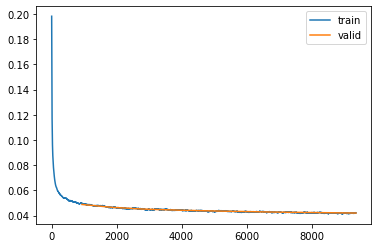

In [16]:
learn_ae.recorder.plot_loss()

In [17]:
preds = learn_ae.get_preds()
z = array(preds[0][1])

#### Plot z values for `2` and `7`

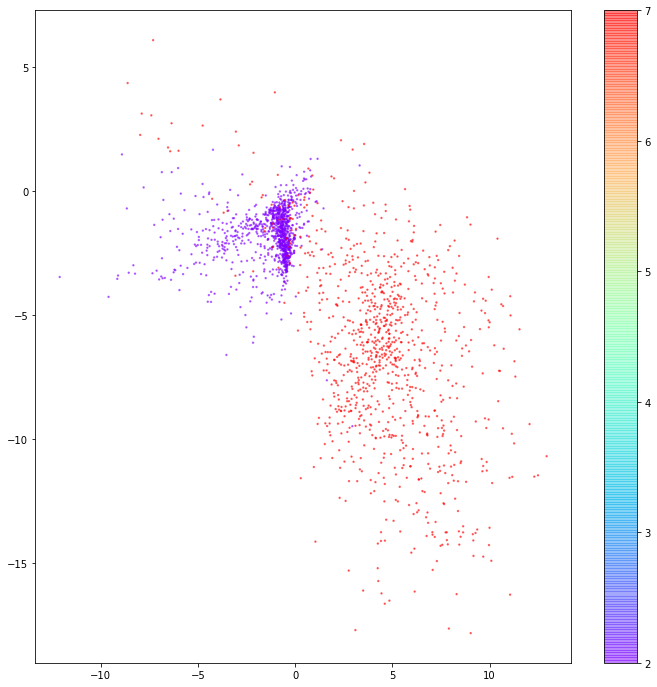

In [18]:
plot_z(z,z_labels,sample=2000,shuff=False)

In [19]:
assert [2,7] == list(np.unique(z_labels[:2000])) 

#### Plot z values for  all images 5000 samples

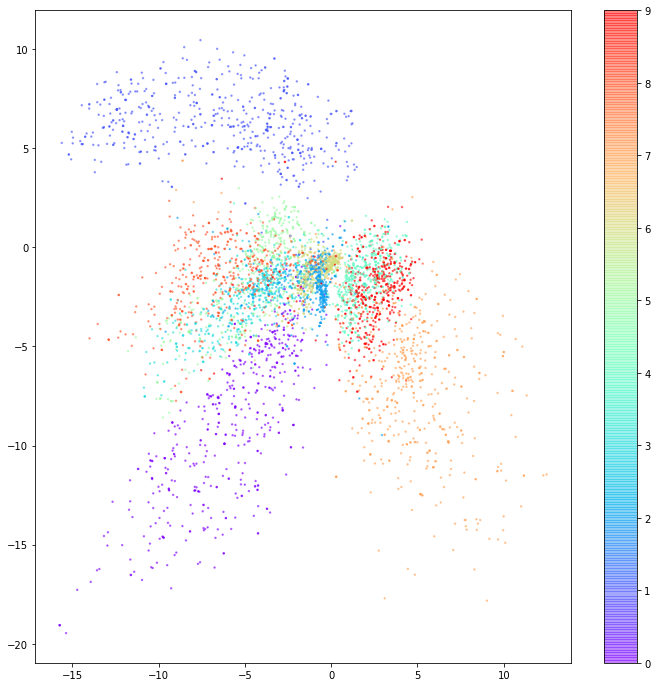

In [20]:
plot_z(z,z_labels,sample=5000,shuff=True)

In [21]:
with torch.no_grad():
    sample = torch.randn(64, 2).to(dls.device)
    sample = learn_ae.model.decode(sample).cpu()

In [22]:
ae_samp_out = show_grid_image(sample)

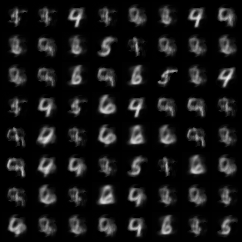

In [23]:
ae_samp_out

## Training a Variational Auto Encoder

In [24]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

class Encode(Module):
    def __init__(self):
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        
    def forward(self,x):
        x = x.view(-1,784)
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return reparameterize(mu,logvar),mu,logvar
    
class Decode(Module):
    def __init__(self):
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def forward(self,x):
        h3 = F.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(h3).view(-1,1,28,28))
    
class VAE(Module):
    def __init__(self):
        self.encode = Encode()
        self.decode = Decode()
 
    def forward(self,x):
        z,mu,logvar = self.encode(x)
        return self.decode(z),z,mu,logvar
    
    


In [27]:
def vae_loss_function(preds,targs):
    recon_x, z,mu,logvar = preds
    recon_loss = F.mse_loss(recon_x, targs,reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD

epoch,train_loss,valid_loss,time
0,2673.155518,2669.095947,00:11
1,2609.290527,2579.538086,00:11
2,2560.827393,2544.714600,00:11
3,2524.769775,2529.991699,00:11
4,2500.443604,2500.983643,00:11
5,2492.718262,2488.232910,00:11
6,2480.916748,2473.281250,00:11
7,2450.224609,2461.258301,00:11
8,2461.113525,2462.897949,00:11
9,2460.434570,2449.450928,00:11


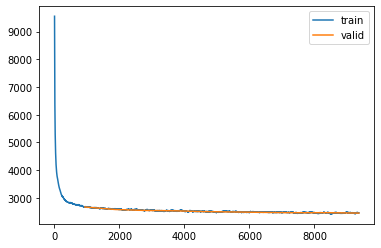

In [28]:
learn_vae = Learner(dls,VAE(),loss_func=vae_loss_function,opt_func=Adam)
learn_vae.fit(10,lr=1e-3)
learn_vae.recorder.plot_loss()

In [30]:
p = learn_vae.get_preds()
z = p[0][1]

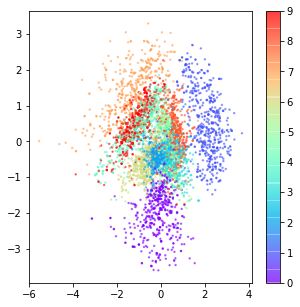

In [31]:
plot_z(z,z_labels,sample=5000,shuff=True,figsize=(5,5))

In [34]:
with torch.no_grad():
    sample = torch.randn(64, 2).to(dls.device)
    sample = learn_vae.model.decode(sample).cpu()
    sample = sample.view(-1,1,28,28)

In [35]:
vae_samp_out = show_grid_image(sample)

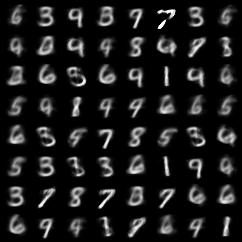

In [36]:
vae_samp_out

## Compare output of AE & VAE

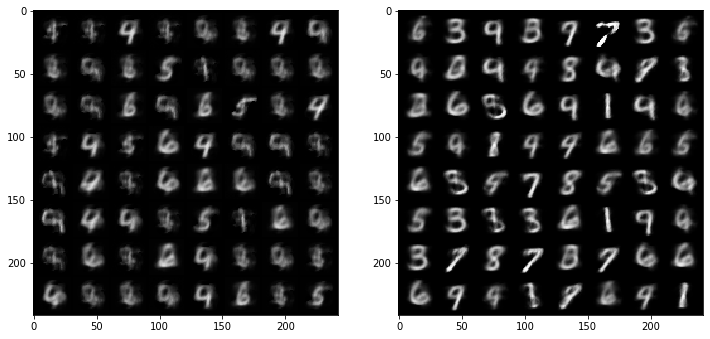

In [37]:
_, axs = plt.subplots(nrows=1,ncols=2, figsize=(12,12));
axs = axs.flatten()
for img,ax in zip([ae_samp_out,vae_samp_out],axs):
    ax.imshow(img)


## Celeb A Dataset

In [41]:
lf = 500
class Encode(Module):
    def __init__(self):
        self.conv_block = nn.Sequential(ConvLayer(3,32,stride=2,act_cls=nn.LeakyReLU),
                                                       ConvLayer(32,64,stride=2,act_cls=nn.LeakyReLU),
                                                       ConvLayer(64,64,stride=2,act_cls=nn.LeakyReLU),
                                                       ConvLayer(64,64,stride=2,act_cls=nn.LeakyReLU),
                                                       Flatten()
                                       )
        self.l1 = nn.Linear(4096,lf)
        self.l2 = nn.Linear(4096,lf)
    
    def forward(self,x):
        x = self.conv_block(x)
        mu = self.l1(x) 
        log_var = self.l2(x)
        return mu,log_var
    
def decode_block(ni,nf,sf=2,act_cls=nn.LeakyReLU,transpose_fn=nn.UpsamplingBilinear2d):
    return nn.Sequential(transpose_fn(scale_factor=sf),ConvLayer(ni,nf,act_cls=act_cls))


class Decode(Module):
    def __init__(self):
        self.conv_block = nn.Sequential(decode_block(64,64,transpose_fn=nn.UpsamplingNearest2d),
                                        decode_block(64,64,transpose_fn=nn.UpsamplingNearest2d),
                                        decode_block(64,32,transpose_fn=nn.UpsamplingNearest2d),
                                        decode_block(32,3,transpose_fn=nn.UpsamplingNearest2d)
                                       
                                       )
        self.l1 = nn.Linear(lf,4096)
        
    def forward(self,x):
        x = self.l1(x)
        x = x.view(-1,64,8,8)
        x = self.conv_block(x)
        return torch.sigmoid(x)


class CelebVAE(Module):
    def __init__(self):
        self.encode = Encode()
        self.decode = Decode()
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self,x):
        mu,log_var = self.encode(x)
        z = self.reparameterize(mu,log_var)
        return self.decode(z), mu, log_var
    
def celeb_loss_function(preds,targs):
    recon_x, mu, logvar = preds
    recon_loss = F.mse_loss(recon_x, targs, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD 

epoch,train_loss,valid_loss,time
0,207195.828125,208661.703125,01:46
1,203545.031250,203668.515625,01:49
2,199774.468750,201047.953125,01:48
3,195098.312500,198386.500000,01:48
4,194514.984375,196040.937500,01:48
5,188086.484375,191333.453125,01:48
6,185030.093750,186861.609375,01:48
7,180481.500000,182786.734375,01:49
8,176466.156250,178276.859375,01:48
9,172709.171875,172902.187500,01:49


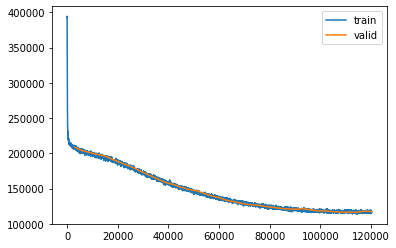

In [42]:
learn_celeb = Learner(dls_celeb,CelebVAE(),loss_func=celeb_loss_function,opt_func=Adam)
learn_celeb.fit_one_cycle(40,lr=1e-3)
learn_celeb.recorder.plot_loss()

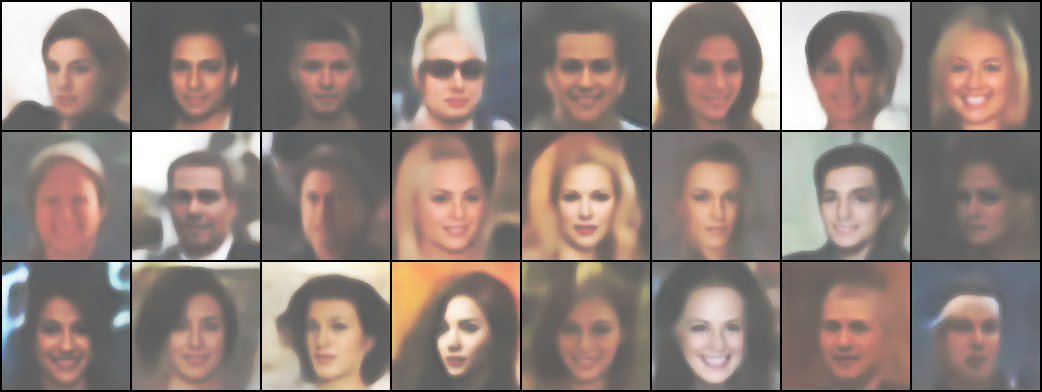

In [43]:
preds= learn_celeb.get_preds()
p_im = preds[0][0]
show_grid_image(p_im[:24])

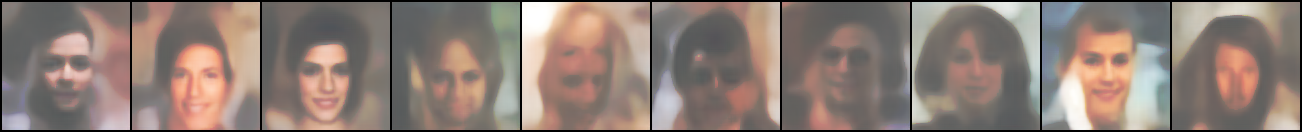

In [45]:
with torch.no_grad():
    sample = torch.randn(64, 500).to(dls_celeb.device)
    sample = learn_celeb.model.decode(sample).cpu()
show_grid_image(sample[:10],nrow=10)